**Action1：资金流入流出预测**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from chinese_calendar import is_holiday

In [2]:
path = 'Purchase Redemption Data/'
# 购买和赎回数据
data = pd.read_csv(path+'user_balance_table.csv', parse_dates=['report_date'])

In [3]:
# 按天聚合
def get_total_balance(data, begin):
    df = data.copy()
    df = df.groupby('report_date', as_index=False)[['total_purchase_amt', 'total_redeem_amt']].sum()
    df = df[df['report_date']>=begin]
    return df
#取比较平稳的数据（3月之后）
total_balance = get_total_balance(data, '2014-03-01')

In [5]:
# 添加时间维度
def add_timestamp(data):
    data['day'] = data['report_date'].dt.day
    data['month'] = data['report_date'].dt.month
    data['weekday'] = data['report_date'].dt.weekday
    data['week'] = data['report_date'].dt.week
    data['year'] = data['report_date'].dt.year

add_timestamp(total_balance)

In [9]:
'''
这里和老师讲的不太一样。
这里是用当个周的平均值，不是整个数据的用平均值。
（感觉这样处理准确一点，避免了每周随时间的总体变化）
'''
# 求出weekday的平均权重
# 这里用当周作为平均值
week_mean = total_balance[['week', 'year', 'total_purchase_amt', 'total_redeem_amt']].groupby(['week', 'year']).mean()
week_mean.columns = ['total_purchase_amt_week_mean', 'total_redeem_amt_week_mean']
# 计算每个weekday的权重
weekday_weight = total_balance[['weekday','week', 'year', 'total_purchase_amt', 'total_redeem_amt']]
weekday_weight = weekday_weight.merge(week_mean, on=['week', 'year'], how='left')
weekday_weight['total_purchase_amt'] /= weekday_weight['total_purchase_amt_week_mean']
weekday_weight['total_redeem_amt'] /= weekday_weight['total_redeem_amt_week_mean']
# 再将权重做平均
weekday_weight = weekday_weight[['weekday', 'total_purchase_amt', 'total_redeem_amt']].groupby('weekday', as_index=False).mean()
weekday_weight.columns = ['weekday', 'purchase_weekday', 'redeem_weekday']

In [10]:
# 日期因子
total_balance = total_balance.merge(weekday_weight, how='left', on='weekday')
# 统计day有几个weekday
weekday_count = total_balance[['report_date', 'day', 'weekday']].groupby(['day', 'weekday'], as_index=False).count()
weekday_count = weekday_count.merge(weekday_weight, how='left', on='weekday')
# 总的weekday的权重
weekday_count['purchase_weekday'] = weekday_count['purchase_weekday']*weekday_count['report_date']
weekday_count['redeem_weekday'] = weekday_count['redeem_weekday']*weekday_count['report_date']
# 每个day的weekday影响
day_rate = weekday_count.drop(['weekday'], axis=1).groupby('day', as_index=False).sum()
day_rate['purchase_weekday'] /= day_rate['report_date']
day_rate['redeem_weekday'] /= day_rate['report_date']
day_rate.drop(['report_date'], axis=1, inplace=True)

In [11]:
# 每个day的平均值（含weekday影响）
day_mean = total_balance[['day', 'total_purchase_amt', 'total_redeem_amt']].groupby('day', as_index=False).mean()
# 去掉weekday的影响，得到纯净的base
day_base = pd.merge(day_mean, day_rate, on='day', how='left')
day_base['total_purchase_amt'] /= day_base['purchase_weekday']
day_base['total_redeem_amt'] /= day_base['redeem_weekday']
# 生成日期数据
day_base['report_date'] = day_base['day'].apply(lambda x: dt.datetime(2014, 9, x) if x<31 else None)
# 去掉最后一行(31号),9月没有31号
day_base.drop(day_base.tail(1).index, inplace=True)

In [12]:
# 计算9月每个day对应的weekday
day_base['weekday'] = day_base['report_date'].dt.weekday
day_base['weekday'] = day_base.apply(add_holiday, axis=1)
# 利用base和weekday权重进行计算
day_pred = day_base[['day', 'total_purchase_amt', 'total_redeem_amt', 'report_date','weekday']]
day_pred = day_pred.merge(weekday_weight, on='weekday')
# 加上weekday权重
day_pred['total_purchase_amt'] *= day_pred['purchase_weekday']
day_pred['total_redeem_amt'] *= day_pred['redeem_weekday']

In [13]:
# 保存结果
day_pred = day_pred.sort_values('report_date')[['report_date','total_purchase_amt', 'total_redeem_amt']]
day_pred['report_date'] = day_pred['report_date'].apply(lambda x: str(x.date()).replace('-', ''))
day_pred.to_csv('period_week_from3_holiday.csv', header=None, index=None)

**这样得到的分数已经有135分**  
后面做了模型融合，用10%\*prophet(104分)+10%\*lightGBM(120分)+80%\*周期因子(135分)=138分
提升十分有限，还需调参。

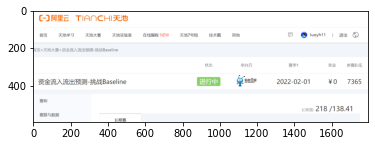

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('score.png')
plt.imshow(img)

**Action2：新闻内容自动提取及呈现**

In [19]:
import requests
from bs4 import BeautifulSoup
import jieba.posseg as pseg
import jieba
from textrank4zh import TextRank4Keyword, TextRank4Sentence
from wordcloud import WordCloud
import re

In [51]:
# 新闻网址(一个关于斯诺克新闻)
url = 'http://news.cnhubei.com/content/2021-01/27/content_13598200.html'

In [52]:
# 读取网页内容
html = requests.get(url, timeout=10)
content = html.content

In [53]:
# 得到文本
soup = BeautifulSoup(content, 'html.parser', from_encoding='utf-8')
text = soup.get_text()

In [54]:
# 分词
words = pseg.lcut(text)

In [55]:
news_person = {word for word, flag in words if flag=='nr'}
news_place = {word for word, flag in words if flag=='ns'}
print('新闻中人名：', news_person)
print('新闻中地名：', news_place)

新闻中人名： {'特鲁姆', '宾汉姆', '山复绿', '颜丙涛', '冉冉升起', '马良', '史蒂夫', '公开赛', '亚军', '斯诺克', '高新区', '戴维斯', '荆楚号', '文明', '有多强', '连闯', '斯宾塞', '迎客', '周', '世锦赛', '荆楚网', '连克', '丁俊晖', '老寺', '刚刚开始', '黄盖湖', '英锦赛', '马克', '大师赛', '许可证', '高峰', '华丽', '李行', '希金斯', '罗伯逊', '赵心童', '迎春', '桂冠', '双子星'}
新闻中地名： {'中欧', '黑马', '山东', '兴山', '青春', '澳大利亚', '武汉', '陕西', '欧洲', '四关', '威尔士', '英伦', '陕', '跃龙', '中国', '奥沙利', '枣阳', '伦敦', '湖北', '新高峰', '宜昌', '赤壁市', '北京郊区', '英国', '北京', '沙洋', '夕阳'}


In [56]:
# 提取中文以及相关标点
text = re.sub('^[\u4e00-\u9fa5。，！：、]{3,}', '', text)

In [67]:
# 把分词之后的一些无用词删除
def remove_stop_words(seg_list):
#     stop_words = ['在', '的', '将', '等', '对', '例', '了', '和', '其他', '是', '共', '对此', '并', '时候', '月', '日']
    stop_words = ['了', '的', '年', '和', '自己', '也', '他', '在', '为', '并', '上', '下']
    f = []
    for word in seg_list:
        if word not in stop_words:
            f.append(word)
    return f
# 生成词云
def create_word_cloud(f):
    # 先进行分词
    seg_list = jieba.lcut(f)
    # 去掉无用词
    seg_list = remove_stop_words(seg_list)
    cut_text = ' '.join(seg_list)
    # 生成词云
    wc = WordCloud(max_words=100, width=2000, height=1200, font_path='L11/news/msyh.ttf')
    wordcloud = wc.generate(cut_text)
    # 保存成图片
    wordcloud.to_file("wordcloud.jpg")
    return wordcloud

In [68]:
# 生成词云
wordcolud = create_word_cloud(text)

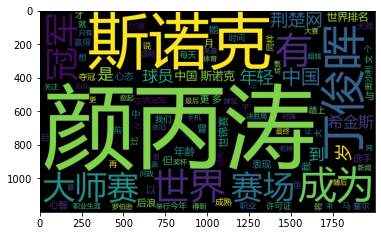

In [69]:
# 显示词云
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('wordcloud.jpg')
imgplot = plt.imshow(img)
plt.show()

In [71]:
# 输出关键词，设置文本小写，窗口为2
tr4w = TextRank4Keyword()
tr4w.analyze(text=text, lower=True, window=2)
print('关键词：')
for item in tr4w.get_keywords(20, word_min_len=1):
    print(item.word, item.weight)

# 生成摘要
tr4s = TextRank4Sentence()
tr4s.analyze(text=text, lower=True, source='all_filters')
print('摘要：')
for item in tr4s.get_key_sentences(num=3):
    print(item.index, item.weight, item.sentence)


关键词：
颜丙涛 0.03178533527620457
斯诺克 0.021881457607610365
世界 0.009576615276536329
下 0.009213037586536134
冠军 0.008877137738447767
成为 0.00864720559862226
中国 0.008401397598525776
赛场 0.00747008795841058
希金斯 0.007337904636767845
大师赛 0.006756458058942472
荆楚网 0.006571512492097199
丁俊晖 0.006229138857437767
年龄 0.0053013153118699145
球员 0.005198513043908168
时间 0.005019069642684015
许可证 0.004677973550439428
世界排名 0.004482764060021335
工程 0.004389492429890344
编辑 0.0043774108238799694
打球 0.004198520243510265
摘要：
100 0.017758457976181547 同样是年少成名、同样是备受关注，问鼎大师赛后，有更多人将颜丙涛视为中国斯诺克的下一个丁俊晖，期待他再攀高峰，触碰世界冠军的奖杯
99 0.015785890361096358 在探路者的感染下，颜丙涛也凭借着“每天10小时以上”的练习，成为中国斯诺克冉冉升起的新星
101 0.015749475383765053 今年4月，斯诺克世锦赛将再度打响，丁俊晖和颜丙涛这对斯诺克双子星，将继续向中国首个斯诺克世界冠军发起冲击
